In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch
from sklearn.preprocessing import StandardScaler

In [2]:
dict_params = {'data': {'len_input': 100, 'delta': 1, 'horizon_forecast': 20, 'size_train': 0.8, 'size_valid': 0.2},
               'model': {'n_comp_trend': 3, 'n_neur_hidden': 100, 'frac_dropout': 0.2},
               'training': {'batch_size': 128, 'n_epochs': 500, 'patience': 50, 'min_delta_loss_perc': 0.01}}

In [46]:
class Block(torch.nn.Module):
    def __init__(self, dict_params: dict, component: str, num_features: int) -> None:
        '''
        Block of the N-BEATS architecture.
        
        Args:
            dict_params: Dictionary containing the configuration settings.
            component: String representing the component to be modelled; it can be either 'trend' or 'seasonality'.
            num_features: Number of features of the input series.
            
        Returns: None
        '''
        super().__init__()
        #
        len_input = dict_params['data']['len_input']
        horizon_forecast = dict_params['data']['horizon_forecast']
        n_comp_trend = dict_params['model']['n_comp_trend']
        n_neur_hidden = dict_params['model']['n_neur_hidden']
        frac_dropout = dict_params['model']['frac_dropout']
        self.component = component
        self.horizon_forecast = horizon_forecast
        self.n_comp_trend = n_comp_trend
        # hidden layers of the FC stack
        self.dense_hid_1 = torch.nn.Linear(in_features = len_input*num_features, out_features = n_neur_hidden)
        self.dense_hid_2 = torch.nn.Linear(in_features = n_neur_hidden, out_features = n_neur_hidden)
        self.dense_hid_3 = torch.nn.Linear(in_features = n_neur_hidden, out_features = n_neur_hidden)
        self.dense_hid_4 = torch.nn.Linear(in_features = n_neur_hidden, out_features = n_neur_hidden)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p = frac_dropout)
        self.batch_norm_1 = torch.nn.BatchNorm1d(n_neur_hidden)
        self.batch_norm_2 = torch.nn.BatchNorm1d(n_neur_hidden)
        self.batch_norm_3 = torch.nn.BatchNorm1d(n_neur_hidden)
        self.batch_norm_4 = torch.nn.BatchNorm1d(n_neur_hidden)
        # dense layer for producing the theta's
        self.dense_theta_b = torch.nn.Linear(in_features = n_neur_hidden, out_features = n_neur_hidden, bias = False)
        if component == 'trend':
            self.dense_theta_f = torch.nn.Linear(in_features = n_neur_hidden, out_features = self.n_comp_trend + 1, bias = False)
        if component == 'seasonality':
            self.dense_theta_f = torch.nn.Linear(in_features = n_neur_hidden, out_features = 2*int(np.floor(horizon_forecast/2-1)) + 1, bias = False)
        # trend and seasonality matrices
        self.mat_T = np.hstack([(np.arange(horizon_forecast).reshape(-1, 1)/horizon_forecast)**p for p in range(n_comp_trend+1)]).astype(np.float32)
        self.mat_S = np.hstack([np.arange(horizon_forecast).reshape(-1, 1)**0] +
                               [np.cos(2*np.pi*i*np.arange(horizon_forecast).reshape(-1, 1)/horizon_forecast) for i in
                                range(1, int(np.floor(horizon_forecast/2-1)) + 1)] +
                               [np.sin(2*np.pi*i*np.arange(horizon_forecast).reshape(-1, 1)/horizon_forecast) for i in
                                range(1, int(np.floor(horizon_forecast/2-1)) + 1)]).astype(np.float32)
        self.mat_T, self.mat_S = torch.tensor(self.mat_T), torch.tensor(self.mat_S)
        # final layer for backcasting
        self.dense_x_hat = torch.nn.Linear(in_features = n_neur_hidden, out_features = len_input)
        
    def forward(self, x):
        y = self.dense_hid_1(x).transpose(1, 2)
        y = self.batch_norm_1(y).transpose(1, 2)
        y = self.relu(y)
        y = self.dropout(y)
        for i in range(3):
            hidden_layer = [self.dense_hid_2, self.dense_hid_3, self.dense_hid_4][i]
            batch_norm = [self.batch_norm_2, self.batch_norm_3, self.batch_norm_4][i]
            y = hidden_layer(y).transpose(1, 2)
            y = batch_norm(y).transpose(1, 2)
            y = self.relu(y)
            y = self.dropout(y)
        # compute theta's
        theta_b = self.dense_theta_b(y)
        theta_f = self.dense_theta_f(y).transpose(1, 2)
        # compute backcast
        x_hat = self.dense_x_hat(theta_b)
        # compute time series components
        if self.component == 'trend':
            y_hat = torch.matmul(self.mat_T.repeat(theta_f.shape[0], 1, 1), theta_f).transpose(1, 2)
        if self.component == 'seasonality':
            y_hat = torch.matmul(self.mat_S.repeat(theta_f.shape[0], 1, 1), theta_f).transpose(1, 2)
        #
        y_hat = y_hat[:, :1, :]
        #
        return x_hat, y_hat

class Stack(torch.nn.Module):
    def __init__(self, dict_params: dict, component: str, num_features: int) -> None:
        '''
        Stack of the N-BEATS architecture.
        
        Args:
            dict_params: Dictionary containing the configuration settings.
            component: String representing the component to be modelled; it can be either 'trend' or 'seasonality'.
            num_features: Number of features of the input series.
            
        Returns: None
        '''
        super().__init__()
        #
        self.block_1 = Block(dict_params = dict_params, component = component, num_features = num_features)
        self.block_2 = Block(dict_params = dict_params, component = component, num_features = num_features)
        self.block_3 = Block(dict_params = dict_params, component = component, num_features = num_features)
        
    def forward(self, x):
        # first block
        x_hat, y = self.block_1(x)
        x = x - x_hat
        y_hat = y
        # second block
        x_hat, y = self.block_2(x)
        x = x - x_hat
        y_hat += y
        # third block
        x_hat, y = self.block_3(x)
        x = x - x_hat
        y_hat += y
        #
        x_hat = x
        return x_hat, y_hat

class NBeats(torch.nn.Module):
    def __init__(self, dict_params: dict, num_features: int) -> None:
        '''
        N-BEATS architecture.
        
        Args:
            dict_params: Dictionary containing the configuration settings.
            num_features: Number of features of the input series.
            
        Returns: None
        '''
        super().__init__()
        #
        self.stack_trend = Stack(dict_params = dict_params, component = 'trend', num_features = num_features)
        self.stack_seas = Stack(dict_params = dict_params, component = 'seasonality', num_features = num_features)
        
    def forward(self, x):
        # trend stack
        x_hat, y_hat_trend = self.stack_trend(x)
        x = x - x_hat
        # seasonality stack
        _, y_hat_seas = self.stack_seas(x)
        #
        return y_hat_trend, y_hat_seas

In [4]:
def train_test_splitting(df: pd.DataFrame, dict_params: dict) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    '''
    Function to split data in training, validation and test set.

    Args:
        df: Dataframe containing time series. The column representing the main series should be called `y`.
        dict_params: Dictionary containing information about the model architecture.

    Returns:
        df_train: Dataframe corresponding to training set.
        df_valid: Dataframe corresponding to validation set.
        df_test: Dataframe corresponding to test set.
    '''
    df_train = df.iloc[:int(df.shape[0]*dict_params['data']['size_train'])].copy().reset_index(drop = True)
    df_test = df.iloc[int(df.shape[0]*dict_params['data']['size_train']):].reset_index(drop = True).copy().reset_index(drop = True)
    df_valid = df_train.iloc[int(df_train.shape[0]*(1 - dict_params['data']['size_valid'])):].copy().reset_index(drop = True)
    df_train = df_train.iloc[:int(df_train.shape[0]*(1 - dict_params['data']['size_valid']))].copy().reset_index(drop = True)
    # rescale data
    scaler = StandardScaler().fit(df_train[['y']])
    df_train[['y']] = scaler.transform(df_train[['y']])
    df_valid[['y']] = scaler.transform(df_valid[['y']])
    df_test[['y']] = scaler.transform(df_test[['y']])
    #
    return df_train, df_valid, df_test, scaler

In [14]:
def get_x_y(df: pd.DataFrame, df_future: pd.DataFrame, dict_params: dict, test_set: bool = False,
            horizon_forecast: int = None) -> (torch.tensor, torch.tensor, np.array, np.array):
    '''
    Function obtain a tensor of regressors and one of target series.

    Args:
        df: Dataframe containing time series. The column representing the main series should be called `y`.
        df_future: Same as `df`, but corresponding to its future (e.g., `df_valid` could be the "future" of `df_train`).
        dict_params: Dictionary containing information about the model architecture.
        test_set: Whether `df` is the dataframe corresponding to test set.
        horizon_forecast: Length of the series to be predicted.

    Returns:
        x: Tensor representing regressors.
        y: Tensor representing target time series.
        date_x: Array containing the dates corresponding to the elements of `x`.
        date_y: Array containing the dates corresponding to the elements of `y`.
    '''
    dict_params = dict_params['data']
    #
    len_input = dict_params['len_input']
    delta = dict_params['delta']
    if (horizon_forecast is None) or (horizon_forecast >= len_input):
        horizon_forecast = len_input
    #
    df_present = df.copy()
    if test_set == False:
        df_future = pd.concat((df_present, df_future)).copy().shift(-len_input)
        df_future = df_future.iloc[:df_present.shape[0]].reset_index(drop = True)
    else:
        df_future = df_present.copy().shift(-len_input).dropna()
        df_present = df_present.iloc[:df_future.shape[0]]
    #
    x = np.array([df_present.loc[i: i + len_input - 1,
                                 [col for col in df_present.columns if col != 'date']].values for i in range(0, df_present.shape[0] - len_input, delta)])
    y = np.array([df_future.loc[i: i + horizon_forecast - 1, ['y']].values for i in range(0, df_future.shape[0] - horizon_forecast, delta)])
    date_x = np.array([df_present.loc[i: i + len_input - 1, 'date'].values for i in range(0, df_present.shape[0] - len_input, delta)])
    date_y = np.array([df_future.loc[i: i + horizon_forecast - 1, 'date'].values for i in range(0, df_future.shape[0] - horizon_forecast, delta)])
    #
    y = y[:x.shape[0]]
    date_y = date_y[:date_x.shape[0]]
    #
    x = torch.tensor(x.astype(np.float32)).transpose(1, 2)
    y = torch.tensor(y.astype(np.float32)).transpose(1, 2)
    #
    date_x = date_x.reshape(x.shape[0], 1, -1)
    date_y = date_y.reshape(y.shape[0], 1, -1)
    #
    return x, y, date_x, date_y

In [6]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        '''
        Class to create a PyTorch dataset.
        
        Args:
            x: Tensor representing regressors.
            y: Tensor representing target time series.
            
        Returns: None.
        '''
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [7]:
class TrainNBeats:
    def __init__(self, model: torch.nn.Module, dict_params: dict, dataloader_train: torch.utils.data.DataLoader, dataloader_valid: torch.utils.data.DataLoader):
        '''
        Class to train the N-BEATS model.
        
        Args:
            model: PyTorch model.
            dict_params: Dictionary containing information about the model architecture.
            dataloader_train: Dataloader containing training data.
            dataloader_valid: Dataloader containing validation data.
            
        Returns: None.
        '''
        self.model = model
        self.dict_params = dict_params
        self.loss_func = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(params = model.parameters())
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = self.optimizer, factor = 0.5)
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid

    def _model_on_batch(self, batch: tuple, training: bool, loss_epoch: float) -> float:
        '''
        Function to perform training on a single batch of data.
        
        Args:
            batch: Batch of data to use for training/evaluation.
            training: Whether to perform training (if not, evaluation is understood).
            loss_epoch: Loss of the current epoch.
            
        Returns:
            loss: Value of the loss function.
        '''
        if training == True:
            self.optimizer.zero_grad()
        #
        x, y_true = batch
        x = x.to('cpu')
        y_true = y_true.to('cpu')
        y_hat_trend, y_hat_seas = self.model(x)
        y_hat_trend = y_hat_trend.to('cpu')
        y_hat_seas = y_hat_seas.to('cpu')
        #
        loss = self.loss_func(y_hat_trend + y_hat_seas, y_true)
        #
        if training == True:
            loss.backward()
            self.optimizer.step()
        #
        return loss.item()

    def _train(self) -> float:
        '''
        Function to train the N-BEATS model on a single epoch.
        
        Args: None.
            
        Returns:
            loss: Value of the training loss function per batch.
        '''
        self.model.train()
        loss_epoch = 0
        for batch in self.dataloader_train:
            loss_epoch += self._model_on_batch(batch = batch, training = True, loss_epoch = loss_epoch)
        return loss_epoch/len(self.dataloader_train)

    def _eval(self) -> float:
        '''
        Function to evaluate the N-BEATS model on the validation set on a single epoch.
        
        Args: None.
            
        Returns:
            loss: Value of the validation loss function per batch.
        '''
        self.model.eval()
        loss_epoch = 0
        with torch.no_grad():
            for batch in self.dataloader_valid:
                loss_epoch += self._model_on_batch(batch = batch, training = False, loss_epoch = loss_epoch)
        return loss_epoch/len(self.dataloader_valid)

    def train_model(self) -> (torch.nn.Module, list, list):
        '''
        Function to train the N-BEATS model.
        
        Args: None.
            
        Returns:
            model: Trained N-BEATS model.
            list_loss_train: List of training loss function across the epochs.
            list_loss_valid: List of validation loss function across the epochs.
        '''
        dict_params = self.dict_params
        n_epochs = dict_params['training']['n_epochs']
        list_loss_train, list_loss_valid = [], []
        counter_patience = 0
        for epoch in range(1, n_epochs + 1):
            loss_train = self._train()
            loss_valid = self._eval()
            #
            if (len(list_loss_valid) > 0) and (loss_valid >= np.min(list_loss_valid)*(1 - dict_params['training']['min_delta_loss_perc'])):
                counter_patience += 1
            if (len(list_loss_valid) == 0) or ((len(list_loss_valid) > 0) and (loss_valid < np.min(list_loss_valid))):
                counter_patience = 0
                torch.save(self.model.state_dict(), '../data/artifacts/weights.p')
            if counter_patience >= dict_params['training']['patience']:
                print(f'Training stopped at epoch {epoch}. Restoring weights from epoch {np.argmin(list_loss_valid) + 1}.')
                self.model.load_state_dict(torch.load('../data/artifacts/weights.p'))
                break
            #
            print(f'Epoch {epoch}: training loss = {loss_train:.4f}, validation loss = {loss_valid:.4f}, patience counter = {counter_patience}.')
            self.scheduler.step(loss_valid)
            #
            list_loss_train.append(loss_train)
            list_loss_valid.append(loss_valid)
        if epoch == n_epochs:
            self.model.load_state_dict(torch.load('../data/artifacts/weights.p'))
        return self.model, list_loss_train, list_loss_valid

In [8]:
def get_y_true_y_hat(model: torch.nn.Module, x: torch.tensor, y: torch.tensor, date_y: np.array,
                     scaler: sklearn.preprocessing.StandardScaler) -> (np.array, np.array, np.array):
    '''
    Function to get the real time series and its prediction.
    
    Args:
        model: Trained N-BEATS model.
        x: Tensor representing regressors.
        y: Tensor representing target time series.
        date_y: Array containing the dates corresponding to the elements of `y`.
        scaler: Scaled used to rescale data.
        
    Returns:
        y_true: Array containing the true values.
        y_hat_trend: Array containing the predicted trend.
        y_hat_seas: Array containing the predicted seasonality.
    '''
    list_date = []
    y_true = []
    y_hat_trend, y_hat_seas = [], []
    pred_trend, pred_seas = model(x)
    for i in range(np.unique(date_y).shape[0]):
        date = np.unique(date_y)[i]
        list_date.append(date)
        idx = np.where(date_y == date)
        y_true.append(y.numpy()[idx].mean())
        y_hat_trend.append(pred_trend.detach().numpy()[idx].mean())
        y_hat_seas.append(pred_seas.detach().numpy()[idx].mean())
    y_true = np.array(y_true)
    y_hat_trend = np.array(y_hat_trend)
    y_hat_seas = np.array(y_hat_seas)
    # scale back
    y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).ravel()
    y_hat_trend = scaler.inverse_transform(y_hat_trend.reshape(-1, 1)).ravel()
    y_hat_seas = scaler.inverse_transform(y_hat_seas.reshape(-1, 1)).ravel()
    #
    return y_true, y_hat_trend, y_hat_seas

In [9]:
def compute_mape(y_true: np.array, y_hat_trend: np.array, y_hat_seas: np.array, scaler: sklearn.preprocessing.StandardScaler) -> float:
    '''
    Function to compute the MAPE.
    
    Args:
        y_true: Array containing the true values.
        y_hat_trend: Array containing the predicted trend.
        y_hat_seas: Array containing the predicted seasonality.
        scaler: Scaled used to rescale data.
        
    Returns:
        mape: MAPE computed from `y_true` and `y_hat`.
    '''
    y_hat = y_hat_trend + y_hat_seas - scaler.mean_
    mape = np.mean(abs(y_true[y_true > 0] - y_hat[y_true > 0])/y_true[y_true > 0])
    return mape

In [15]:
df = pd.read_csv('../data/raw/train.csv', parse_dates = ['date'], index_col = 'id')
df = df.groupby(['date', 'family']).agg({'sales': 'sum'}).reset_index()
# add all dates
df_temp = []
for family in df['family'].unique():
    df_temp.append(pd.DataFrame({'date': pd.date_range(df['date'].min(), df['date'].max())}).merge(df[df['family'] == family],
                                                                                                on = 'date', how = 'left'))
    df_temp[-1]['family'] = family
    df_temp[-1]['sales'] = df_temp[-1]['sales'].ffill()
df = pd.concat(df_temp).reset_index(drop = True)
del df_temp
df = df.rename(columns = {'sales': 'y'})
# perform train-test splitting
df_train, df_valid, df_test, scaler = train_test_splitting(df = df[df['family'] == 'AUTOMOTIVE'].reset_index(drop = True).drop('family', axis = 1),
                                                        dict_params = dict_params)
#
horizon_forecast = dict_params['data']['horizon_forecast']
# training set data
x_train, y_train, date_x_train, date_y_train = get_x_y(df = df_train, df_future = df_valid, dict_params = dict_params,
                                                    test_set = False, horizon_forecast = horizon_forecast)
# validation set data
x_valid, y_valid, date_x_valid, date_y_valid = get_x_y(df = df_valid, df_future = df_test, dict_params = dict_params,
                                                    test_set = False, horizon_forecast = horizon_forecast)
# test set data
x_test, y_test, date_x_test, date_y_test = get_x_y(df = df_test, df_future = None, dict_params = dict_params, test_set = True,
                                                horizon_forecast = horizon_forecast)
# create datasets and dataloader
dataset_train = CreateDataset(x = x_train, y = y_train)
dataset_valid = CreateDataset(x = x_valid, y = y_valid)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = dict_params['training']['batch_size'], shuffle = True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size = dict_params['training']['batch_size'], shuffle = False)
# train model

Epoch 1: training loss = 6.2823, validation loss = 1.1427, patience counter = 0.
Epoch 2: training loss = 4.8711, validation loss = 1.0857, patience counter = 0.
Epoch 3: training loss = 3.8818, validation loss = 1.0129, patience counter = 0.
Epoch 4: training loss = 3.1790, validation loss = 0.9179, patience counter = 0.
Epoch 5: training loss = 2.7333, validation loss = 0.8450, patience counter = 0.
Epoch 6: training loss = 2.4092, validation loss = 0.8319, patience counter = 0.
Epoch 7: training loss = 2.0986, validation loss = 0.7514, patience counter = 0.
Epoch 8: training loss = 1.8730, validation loss = 0.7867, patience counter = 1.
Epoch 9: training loss = 1.7945, validation loss = 0.6576, patience counter = 0.
Epoch 10: training loss = 1.5209, validation loss = 0.5511, patience counter = 0.
Epoch 11: training loss = 1.5316, validation loss = 0.5044, patience counter = 0.
Epoch 12: training loss = 1.3320, validation loss = 0.5362, patience counter = 1.
Epoch 13: training loss =

Epoch 102: training loss = 0.3640, validation loss = 0.2799, patience counter = 2.
Epoch 103: training loss = 0.3605, validation loss = 0.2760, patience counter = 0.
Epoch 104: training loss = 0.3790, validation loss = 0.2891, patience counter = 1.
Epoch 105: training loss = 0.3669, validation loss = 0.2753, patience counter = 0.
Epoch 106: training loss = 0.3611, validation loss = 0.2748, patience counter = 0.
Epoch 107: training loss = 0.3639, validation loss = 0.2792, patience counter = 1.
Epoch 108: training loss = 0.3592, validation loss = 0.2766, patience counter = 2.
Epoch 109: training loss = 0.3644, validation loss = 0.2816, patience counter = 3.
Epoch 110: training loss = 0.3574, validation loss = 0.2842, patience counter = 4.
Epoch 111: training loss = 0.3647, validation loss = 0.2706, patience counter = 0.
Epoch 112: training loss = 0.3524, validation loss = 0.2795, patience counter = 1.
Epoch 113: training loss = 0.3631, validation loss = 0.2835, patience counter = 2.
Epoc

Epoch 201: training loss = 0.3164, validation loss = 0.2553, patience counter = 2.
Epoch 202: training loss = 0.3114, validation loss = 0.2549, patience counter = 3.
Epoch 203: training loss = 0.3165, validation loss = 0.2574, patience counter = 4.
Epoch 204: training loss = 0.3221, validation loss = 0.2544, patience counter = 5.
Epoch 205: training loss = 0.3173, validation loss = 0.2555, patience counter = 6.
Epoch 206: training loss = 0.3183, validation loss = 0.2550, patience counter = 7.
Epoch 207: training loss = 0.3122, validation loss = 0.2530, patience counter = 8.
Epoch 208: training loss = 0.3193, validation loss = 0.2557, patience counter = 9.
Epoch 209: training loss = 0.3087, validation loss = 0.2518, patience counter = 0.
Epoch 210: training loss = 0.3113, validation loss = 0.2534, patience counter = 1.
Epoch 211: training loss = 0.3183, validation loss = 0.2527, patience counter = 2.
Epoch 212: training loss = 0.3096, validation loss = 0.2570, patience counter = 3.
Epoc

Epoch 300: training loss = 0.3036, validation loss = 0.2468, patience counter = 24.
Epoch 301: training loss = 0.3073, validation loss = 0.2451, patience counter = 25.
Epoch 302: training loss = 0.3113, validation loss = 0.2433, patience counter = 0.
Epoch 303: training loss = 0.2973, validation loss = 0.2467, patience counter = 1.
Epoch 304: training loss = 0.3015, validation loss = 0.2429, patience counter = 0.
Epoch 305: training loss = 0.3009, validation loss = 0.2436, patience counter = 1.
Epoch 306: training loss = 0.3066, validation loss = 0.2463, patience counter = 2.
Epoch 307: training loss = 0.3054, validation loss = 0.2446, patience counter = 3.
Epoch 308: training loss = 0.2994, validation loss = 0.2445, patience counter = 4.
Epoch 309: training loss = 0.3073, validation loss = 0.2460, patience counter = 5.
Epoch 310: training loss = 0.2978, validation loss = 0.2455, patience counter = 6.
Epoch 311: training loss = 0.3016, validation loss = 0.2455, patience counter = 7.
Ep

C:\Users\alled\AppData\Local\Temp\ipykernel_2712\4283204432.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load('../data/artifacts/we

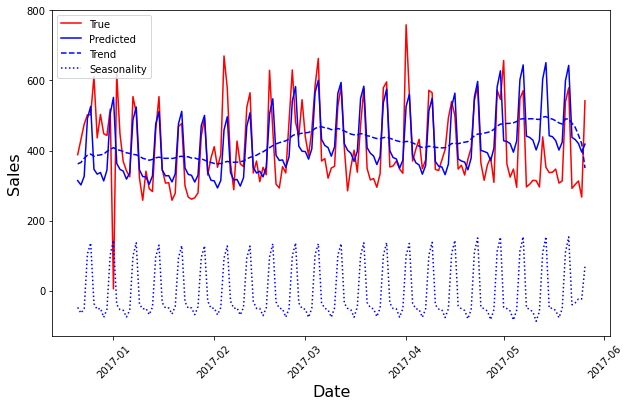

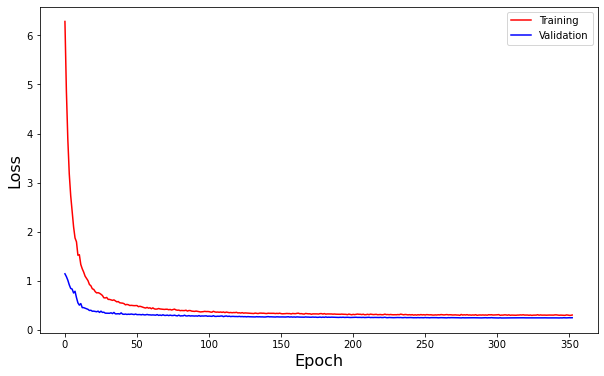

In [51]:
df = pd.read_csv('../data/raw/train.csv', parse_dates = ['date'], index_col = 'id')
df = df.groupby(['date', 'family']).agg({'sales': 'sum'}).reset_index()
# add all dates
df_temp = []
for family in df['family'].unique():
    df_temp.append(pd.DataFrame({'date': pd.date_range(df['date'].min(), df['date'].max())}).merge(df[df['family'] == family],
                                                                                                on = 'date', how = 'left'))
    df_temp[-1]['family'] = family
    df_temp[-1]['sales'] = df_temp[-1]['sales'].ffill()
df = pd.concat(df_temp).reset_index(drop = True)
del df_temp
df = df.rename(columns = {'sales': 'y'})
# perform train-test splitting
df_train, df_valid, df_test, scaler = train_test_splitting(df = df[df['family'] == 'AUTOMOTIVE'].reset_index(drop = True).drop('family', axis = 1),
                                                        dict_params = dict_params)
#
horizon_forecast = dict_params['data']['horizon_forecast']
# training set data
x_train, y_train, date_x_train, date_y_train = get_x_y(df = df_train, df_future = df_valid, dict_params = dict_params,
                                                    test_set = False, horizon_forecast = horizon_forecast)
# validation set data
x_valid, y_valid, date_x_valid, date_y_valid = get_x_y(df = df_valid, df_future = df_test, dict_params = dict_params,
                                                    test_set = False, horizon_forecast = horizon_forecast)
# test set data
x_test, y_test, date_x_test, date_y_test = get_x_y(df = df_test, df_future = None, dict_params = dict_params, test_set = True,
                                                horizon_forecast = horizon_forecast)
# create datasets and dataloader
dataset_train = CreateDataset(x = x_train, y = y_train)
dataset_valid = CreateDataset(x = x_valid, y = y_valid)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = dict_params['training']['batch_size'], shuffle = True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size = dict_params['training']['batch_size'], shuffle = False)
# train model
model = NBeats(dict_params = dict_params, num_features = x_train.shape[1])
model, list_loss_train, list_loss_valid = TrainNBeats(model = model, dict_params = dict_params, dataloader_train = dataloader_train, dataloader_valid = dataloader_train).train_model()
# evaluate results
model = NBeats(dict_params = dict_params, num_features = x_train.shape[1])
model.load_state_dict(torch.load('../data/artifacts/weights.p'))
model.eval()
# get time series and the corresponding predictions
y_true_train, y_hat_trend_train, y_hat_seas_train = get_y_true_y_hat(model = model, x = x_train, y = y_train, date_y = date_y_train, scaler = scaler)
y_true_valid, y_hat_trend_valid, y_hat_seas_valid = get_y_true_y_hat(model = model, x = x_valid, y = y_valid, date_y = date_y_valid, scaler = scaler)
y_true_test, y_hat_trend_test, y_hat_seas_test = get_y_true_y_hat(model = model, x = x_test, y = y_test, date_y = date_y_test, scaler = scaler)
# compute mape on training, validation and test set
mape_train = compute_mape(y_true = y_true_train, y_hat_trend = y_hat_trend_train, y_hat_seas = y_hat_seas_train, scaler = scaler)
mape_valid = compute_mape(y_true = y_true_valid, y_hat_trend = y_hat_trend_valid, y_hat_seas = y_hat_seas_valid, scaler = scaler)
mape_test = compute_mape(y_true = y_true_test, y_hat_trend = y_hat_trend_test, y_hat_seas = y_hat_seas_test, scaler = scaler)
#
plt.figure(figsize = [10, 6])
plt.plot(np.unique(date_y_test), y_true_test, label = 'True', color = 'r')
plt.plot(np.unique(date_y_test), y_hat_trend_test + y_hat_seas_test - scaler.mean_, label = 'Predicted', color = 'b')
plt.plot(np.unique(date_y_test), y_hat_trend_test, label = 'Trend', color = 'b', ls = '--')
plt.plot(np.unique(date_y_test), y_hat_seas_test - scaler.mean_, label = 'Seasonality', color = 'b', ls = ':')
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Sales', fontsize = 16)
plt.xticks(rotation = 45)
plt.legend()
plt.savefig('../docs/figures_for_readme/result', bbox_inches = 'tight')
plt.show()
#
plt.figure(figsize = [10, 6])
plt.plot(list_loss_train, c = 'r', label = 'Training')
plt.plot(list_loss_valid, c = 'b', label = 'Validation')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend()
plt.savefig('../docs/figures_for_readme/loss', bbox_inches = 'tight')
plt.show()